# Compute derivatives of the Prediction (on Omega or Omega_h)

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

## Imports

In [2]:
from scar.utils import read_config,create_tree,get_class
from scar.equations.run_Eikonal2D import *
from scar.equations.run_EikonalLap2D import *
from scar.geometry import Geometry2D

# from scar.solver.solver_fem import FEMSolver
# from scar.solver.solver_phifem import PhiFemSolver
# from scar.correction.correct_pred import *

import torch
from torch.autograd import grad as grad_torch
import dolfin as df
from dolfin import FunctionSpace,Function

import matplotlib.pyplot as plt

Using device: cpu
torch loaded; device is cpu
torch loaded; device is cpu


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


## Define case

In [3]:
form = "Circle"
num_config = 5
sdf_run = run_EikonalLap2D

In [4]:
dir_name = "../../networks/EikonalLap2D/"+form+"/"
models_dir = dir_name+"models/"
config_filename = models_dir+"config_"+str(num_config)+".json"
model_filename = models_dir+"model_"+str(num_config)+".pth"
bc_dir = dir_name+"bc/"
create_tree(bc_dir)

In [5]:
geom_class = get_class(form,Geometry2D)
form = geom_class()

## Récupération du modèle

bc_points.shape = (2000, 2), bc_normals.shape = (2000, 2)
ICIIIII : tv_loss_f =  MSELoss()
>> load network /home/flecourtier/Bureau/Thèse/networks/EikonalLap2D/Circle/models/model_5.pth
norm_grad_norm_gradu : torch.Size([20000, 1])
norm_grad_norm_gradu : torch.Size([20000, 1])


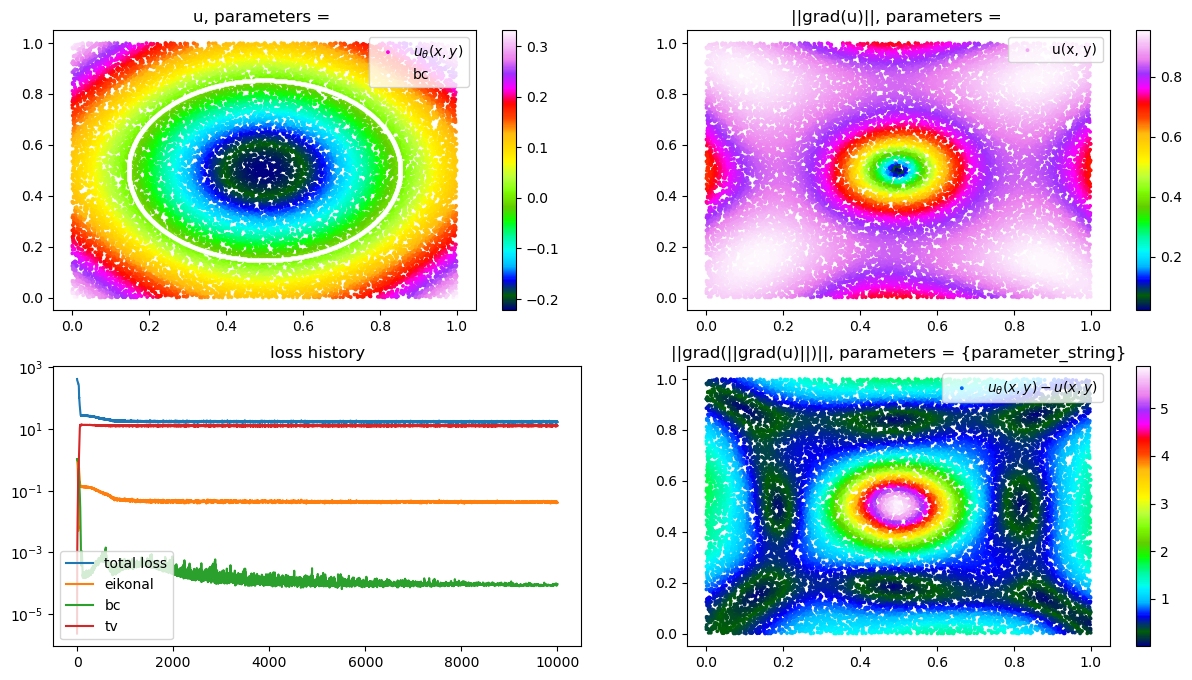

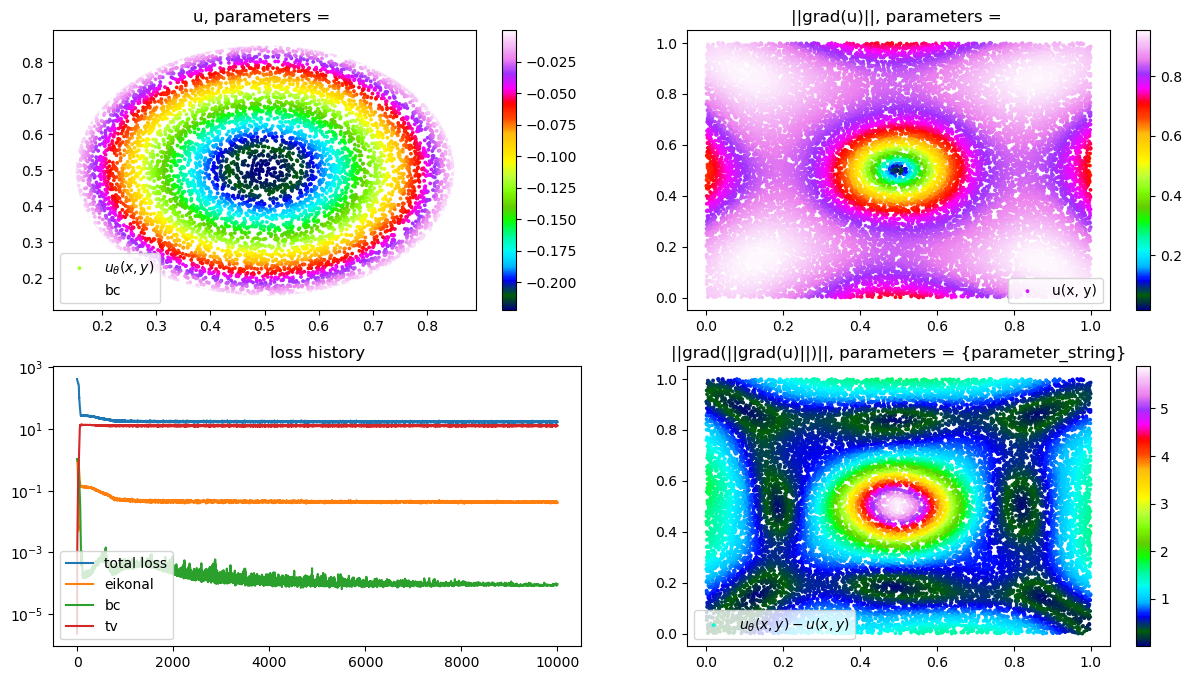

In [6]:
dict_config = read_config(config_filename)

eik,trainer = sdf_run(form,num_config,dict_config,new_training = False,createxyzfile=False)

## Test - BC

In [7]:
n_bc_points = 1000

t = np.linspace(0,1,n_bc_points)
c_t = form.c(t)
c_t = np.array(c_t.T)

grad_c_t = form.c_prime_rot(t,theta=-np.pi/2)
grad_c_t_norm = np.linalg.norm(grad_c_t,axis=0)
normals = grad_c_t/grad_c_t_norm

In [8]:
XY_bc = torch.tensor(c_t,requires_grad=True)

parameter_domain = trainer.pde.parameter_domain
nb_params = len(parameter_domain)
shape = (XY_bc.shape[0],nb_params)
if shape[1] == 0:
    mu_test = torch.zeros(shape)
else:
    ones = torch.ones(shape)
    mu_test = (torch.mean(parameter_domain, axis=1) * ones).to(device)

sdf_bc_dict = trainer.network.setup_w_dict(XY_bc, mu_test)
sdf_bc = sdf_bc_dict["w"][:,0].cpu().detach().numpy()

In [9]:
trainer.network.get_first_derivatives(sdf_bc_dict, XY_bc)
u_x = trainer.eik.pde.get_variables(sdf_bc_dict, "w_x")
u_y = trainer.eik.pde.get_variables(sdf_bc_dict, "w_y")
grad_u = (torch.stack([u_x, u_y])[:,:,0]).transpose(0,1).cpu().detach().numpy()

## SaveFig

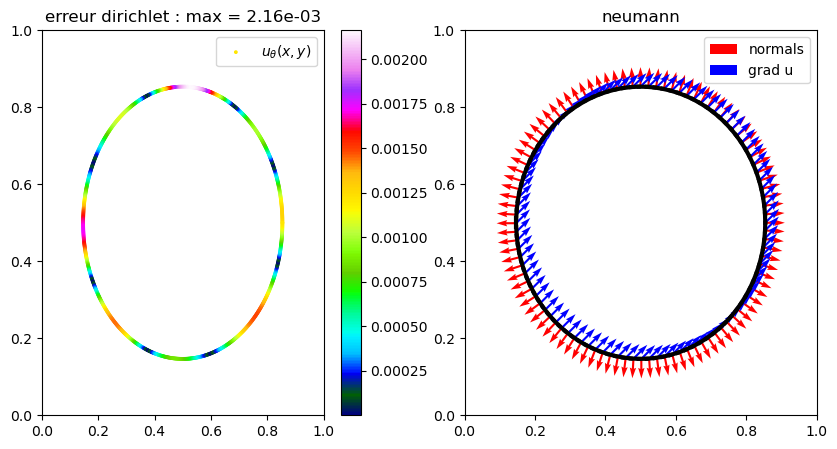

In [10]:
fig = plt.figure(figsize=(10,5))

# Dirichlet
plt.subplot(1,2,1)
im = plt.scatter(
    XY_bc[:, 0].detach().cpu().numpy(),
    XY_bc[:, 1].detach().cpu().numpy(),
    s=3,
    c=abs(sdf_bc),
    cmap="gist_ncar",
    label="$u_{\\theta}(x, y)$",
)
fig.colorbar(im)
plt.title(f"erreur dirichlet : max = {np.max(np.abs(sdf_bc)):.2e}")
plt.legend()
plt.xlim(form.bord_a,form.bord_b)
plt.ylim(form.bord_a2,form.bord_b2)

# Neumann
plt.subplot(1,2,2)
form.plot_curve(color="black")
plt.quiver(c_t.T[0,::10],c_t.T[1,::10],normals[0,::10],normals[1,::10],color="red",label="normals")
plt.quiver(c_t.T[0,::10],c_t.T[1,::10],grad_u[0,::10],grad_u[1,::10],color="blue",label="grad u")
plt.title("neumann")
plt.legend()
plt.xlim(form.bord_a,form.bord_b)
plt.ylim(form.bord_a2,form.bord_b2)

plt.savefig(bc_dir+"bc_"+str(num_config)+".png")